<a href="https://colab.research.google.com/github/masher5764/Garbage-Image-Classification/blob/main/Garbage_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
!unzip '/content/Garbage.zip'

In [3]:
import os
image_dir = '/content/Garbage classification/Garbage classification'
for label, class_dir in enumerate(os.listdir(image_dir)):
  print(label, class_dir)

0 metal
1 plastic
2 glass
3 paper
4 cardboard
5 trash


In [4]:
class ImageDataset(Dataset):
  def __init__(self, image_paths, labels, transform=None):
    self.image_paths = image_paths
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    img_path = self.image_paths[idx]
    image = Image.open(img_path).convert("RGB")
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)

    return image, label

def load_image_paths_and_labels(image_dir):
  image_paths = []
  labels = []
  class_name = {}

  for label, class_dir in enumerate(sorted(os.listdir(image_dir))):
    class_path = os.path.join(image_dir, class_dir)
    if not os.path.isdir(class_path):
      continue
    class_name[label] = class_dir
    for img_name in os.listdir(class_path):
      image_paths.append(os.path.join(class_path, img_name))
      labels.append(label)

  return image_paths, labels, class_name


In [5]:
# 1. Load image paths and labels
image_dir = '/content/Garbage classification/Garbage classification'
image_paths, labels, class_name = load_image_paths_and_labels(image_dir)

# 2. Split into 80% train and 20% test
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# 3. Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 4. Create datasets
train_dataset = ImageDataset(train_paths, train_labels, transform=train_transform)
test_dataset = ImageDataset(test_paths, test_labels, transform=test_transform)

# Access the class_name dictionary directly
print(class_name)

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [6]:
train_image_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=False)
test_image_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [7]:
#for images,labels in train_image_loader:
  #print(images.shape, labels.shape)

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [9]:
print(class_name)
print(class_name)

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


torch.Size([32, 3, 224, 224]) torch.Size([32])
Label index: 5
Label name: trash
Image shape for display: (224, 224, 3)


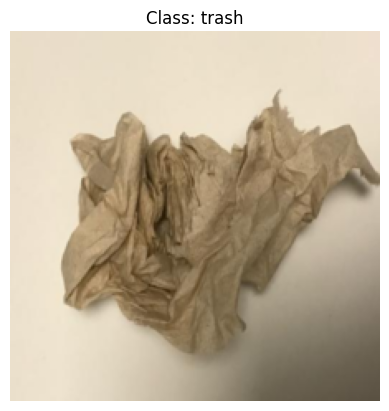

In [32]:
for images, labels in train_image_loader:
  print(images.shape, labels.shape)  # Should be [32, 3, 224, 224] and [32]

  img_tensor = images[0]  # Tensor shape: [3, 224, 224]
  label = labels[0].item()

  print("Label index:", label)
  print("Label name:", class_name[label])

  img = img_tensor.permute(1, 2, 0).numpy()  # Shape: [224, 224, 3]
  print("Image shape for display:", img.shape)

  plt.imshow(img)
  plt.title(f"Class: {class_name[label]}")
  plt.axis('off')
  plt.show()
  break


In [33]:
from collections import Counter

label_counts = Counter(train_labels)
print("Training set class distribution:")
for label, count in label_counts.items():
    print(f"{class_name[label]} ({label}): {count} images")

label_counts = Counter(test_labels)
print("\nTest set class distribution:")
for label, count in label_counts.items():
    print(f"{class_name[label]} ({label}): {count} images")

Training set class distribution:
trash (5): 110 images
glass (1): 401 images
paper (3): 475 images
metal (2): 328 images
plastic (4): 385 images
cardboard (0): 322 images

Test set class distribution:
plastic (4): 97 images
metal (2): 82 images
cardboard (0): 81 images
glass (1): 100 images
paper (3): 119 images
trash (5): 27 images


# Custom CNN Architecture

In [12]:
import torch.nn as nn
import torch.optim as optim

In [13]:
class CustomCnnModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CustomCnnModel, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes

        self.conv_layers = nn.Sequential(
            # C1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # C2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # C3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # C4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self._to_linear = 256 * 14 * 14  # Adjusted to match the feature map size after conv layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self._to_linear, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, self.num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc_layers(x)
        return x

# Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomCnnModel(input_dim=224, num_classes=6).to(device)

print(model)


CustomCnnModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [14]:
# Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomCnnModel(input_dim=128, num_classes=6).to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [16]:
# 100 epoch

# 1000
# 10 batch size
# 100

# 1 epoch --> 100 iteration
# 2 epoch --> 100 iteration

In [17]:
len(train_image_loader)

64

In [18]:
# Training loop
epochs = 40
for epoch in range(epochs):
  model.train()
  running_loss = 0.0
  for images, labels in train_image_loader:
    images,labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    # [x, 3, 128, 128]

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
  print(f"Epoch {epoch+1}/{epochs}, Loss : {running_loss/len(train_image_loader)}")

Epoch 1/40, Loss : 2.7722517009824514
Epoch 2/40, Loss : 1.3220054423436522
Epoch 3/40, Loss : 1.0940581792965531
Epoch 4/40, Loss : 0.9711586833000183
Epoch 5/40, Loss : 0.8706530597992241
Epoch 6/40, Loss : 0.8026480907574296
Epoch 7/40, Loss : 0.7415842106565833
Epoch 8/40, Loss : 0.6847801946569234
Epoch 9/40, Loss : 0.6116724361781962
Epoch 10/40, Loss : 0.5468661215854809
Epoch 11/40, Loss : 0.5024426379241049
Epoch 12/40, Loss : 0.467277895193547
Epoch 13/40, Loss : 0.3957803202793002
Epoch 14/40, Loss : 0.3266704196576029
Epoch 15/40, Loss : 0.29817214503418654
Epoch 16/40, Loss : 0.25227318389806896
Epoch 17/40, Loss : 0.24937875806062948
Epoch 18/40, Loss : 0.20695845497539267
Epoch 19/40, Loss : 0.22234251628105994
Epoch 20/40, Loss : 0.21578800075803883
Epoch 21/40, Loss : 0.17656488198554143
Epoch 22/40, Loss : 0.16282606462482363
Epoch 23/40, Loss : 0.20601740109123057
Epoch 24/40, Loss : 0.15984859538730234
Epoch 25/40, Loss : 0.17741675667639356
Epoch 26/40, Loss : 0.17

In [19]:
for images, labels in test_image_loader:
  print(labels.shape)
  break

torch.Size([32])


In [20]:
# Evaluate model

model.eval()
correct = 0
total = 0

with torch.no_grad():
  for images, labels in test_image_loader:
    images,labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Test accuracy is :{100* correct / total:.2f}%")

Test accuracy is :71.54%


In [21]:
import cv2

In [22]:
class ImageClassifier:
  def __init__(self, model_path, class_names):
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.class_names = class_names
    self.model = CustomCnnModel(input_dim=128, num_classes=len(class_names)).to(self.device)
    self.model.load_state_dict(torch.load(model_path, map_location=self.device))
    self.model.eval()
    self.transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

  def predict(self, image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = self.transform(image).unsqueeze(0).to(self.device)
    with torch.no_grad():
      output = self.model(input_tensor)
      _, predicted = torch.max(output, 1)
    label = self.class_names[predicted.item()]

    img = cv2.imread(image_path)
    cv2.putText(img, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    cv2.imwrite("output_image.jpg", img)
    return label

In [23]:
import os
os.makedirs("/content/saved", exist_ok=True)
torch.save(model.state_dict(), "/content/saved/cnn_model.pth")

In [29]:
# Convert your class_name dict (index to name) into a list
classifier = ImageClassifier("/content/saved/cnn_model.pth", class_name)
# Make a prediction
label = classifier.predict("/content/metal_test_pic.jpg")
print(f"Predicted class is: {label}")


Predicted class is: metal


In [26]:
class_name

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}